In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from keras.applications.imagenet_utils import decode_predictions
import glob
import matplotlib.image as mpimg
import zipfile
from tensorflow.keras.preprocessing import image as tf_image

# Скачиваю архив с данными в папку /tmp/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Распаковываю данные и создаю соответствующие директории

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [45]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Изменение масштаба изображений

## Генераторы нужны для того, чтобы брать изображения с исходных папок, ковернтировать в тензоры float и давать нашей сети

## Также нормализую значения пикселей к диапазону [0, 1]

## Все это реализовано в классе ImageDataGenerator в keras. С помощью него можно конфигурировать подготовку и дополнение данных изображений. 

## Аугментация для тренировочных данных

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, 
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, vertical_flip= True)

## Для тестирования аугментация не нужна, потому что выборка должна быть изначальной

In [9]:
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.)

## Создаю экземпляры генераторов с помощью flow_from_directory. После этого можно использовать эти генераторы в самих моделях

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir, class_mode='binary', target_size=(200, 200))     

validation_generator =  test_datagen.flow_from_directory(validation_dir, class_mode='binary', 
                                                         target_size=(200, 200))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_generator.image_shape, validation_generator.image_shape

((200, 200, 3), (200, 200, 3))

In [12]:
train_generator.samples, validation_generator.samples

(2000, 1000)

In [13]:
def show(path):
    img = mpimg.imread(path)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [14]:
train_generator.filenames[3]

'cats/cat.100.jpg'

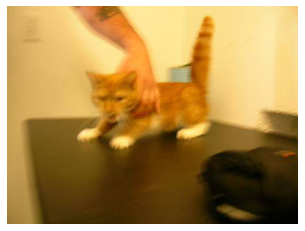

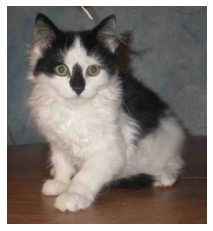

In [15]:
show(train_dir + "/" + train_generator.filenames[0])
show(train_dir + "/" + train_generator.filenames[456])

# Необходимые методы

In [16]:
def get_early_stopping(monitor="val_loss", patience=0):
    return EarlyStopping(monitor=monitor, patience=patience, verbose=1)

def get_board_callback(name):
    log_dir = "logs/fit/"
    return TensorBoard(log_dir=log_dir + name, histogram_freq=1)

In [37]:
def print_metrics(model):
        accuracy = model.history.history['accuracy']
        val_acc = model.history.history['val_accuracy']
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']

        epochs = range(len(accuracy))

        plt.plot(epochs, accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and Validation loss')
        plt.legend()
        plt.figure()

        plt.show()

# Transfer learning

In [30]:
inception = InceptionV3(input_shape = (200, 200, 3), include_top=False)

In [31]:
for layer in inception.layers:
    layer.trainable = False

In [32]:
flatten = Flatten()(inception.output) 
my_dense = Dense(512, activation='relu')(flatten)
dropout = Dropout(0.3)(my_dense)
output = Dense(1, activation='sigmoid')(dropout)
model = Model(inception.input, output)

## Использую binary_crossentropy, потому что мы имеем 2 класса (собака/кот). Бинарная классификация

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [34]:
early_stopping = get_early_stopping(patience=5)
tensor_board = get_board_callback("transfer_learning")
history = model.fit(train_generator, validation_data = validation_generator, 
                    steps_per_epoch=train_generator.samples // 32, 
                    epochs=50, validation_steps=30, verbose=1, callbacks=[early_stopping, tensor_board])

Epoch 1/50
62/62 [==============================] - 40s 591ms/step - loss: 8.4953 - accuracy: 0.7577 - val_loss: 0.1981 - val_accuracy: 0.9708
Epoch 2/50
62/62 [==============================] - 36s 576ms/step - loss: 1.0684 - accuracy: 0.8635 - val_loss: 0.0936 - val_accuracy: 0.9719
Epoch 3/50
62/62 [==============================] - 34s 550ms/step - loss: 0.2898 - accuracy: 0.8674 - val_loss: 0.1005 - val_accuracy: 0.9781
Epoch 4/50
62/62 [==============================] - 34s 554ms/step - loss: 0.2387 - accuracy: 0.8951 - val_loss: 0.0576 - val_accuracy: 0.9802
Epoch 5/50
62/62 [==============================] - 35s 565ms/step - loss: 0.2107 - accuracy: 0.9009 - val_loss: 0.0581 - val_accuracy: 0.9823
Epoch 6/50
62/62 [==============================] - 36s 575ms/step - loss: 0.2184 - accuracy: 0.9068 - val_loss: 0.0584 - val_accuracy: 0.9781
Epoch 7/50
62/62 [==============================] - 38s 619ms/step - loss: 0.2427 - accuracy: 0.8916 - val_loss: 0.0559 - val_accuracy: 0.9844

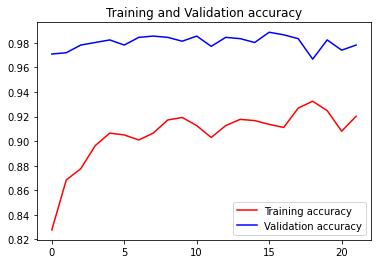

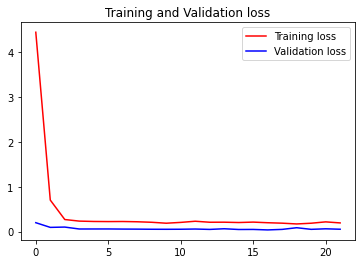

<Figure size 432x288 with 0 Axes>

In [38]:
print_metrics(model)

# Предсказание

In [76]:
def predict(model, path):
    show(path)
    img = tf_image.load_img(path, target_size=(200, 200))
    x = tf_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    print("Dog: " + str(classes[0]) + "\nCat: " + str(1 - classes[0]) + "\n")
    if (classes[0] > 0.5):
        print("This is a dog!")
    else:
        print("This is a cat!")

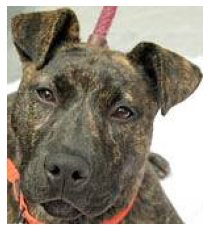

Dog: [1.]
Cat: [0.]

This is a dog!


In [82]:
predict(model, validation_dogs_dir + "/" + "dog.2040.jpg")

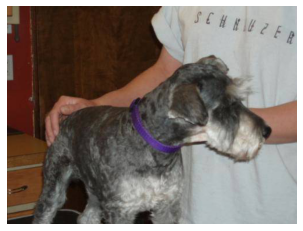

Dog: [0.9999938]
Cat: [6.198883e-06]

This is a dog!


In [89]:
predict(model, validation_dogs_dir + "/" + "dog.2051.jpg")

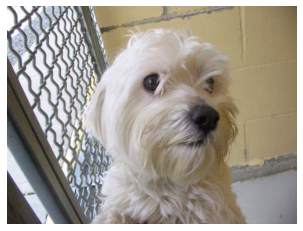

Dog: [1.095381e-08]
Cat: [1.]

This is a cat!


In [78]:
predict(model, validation_dogs_dir + "/" + "dog.2005.jpg")

# Кастомные картинки

In [91]:
custom_dir = "./photo/"

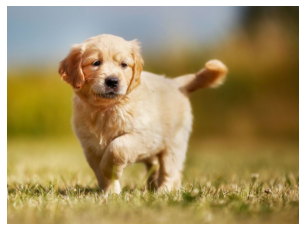

Dog: [0.62808037]
Cat: [0.37191963]

This is a dog!


In [92]:
predict(model, custom_dir + "dog.jpg")

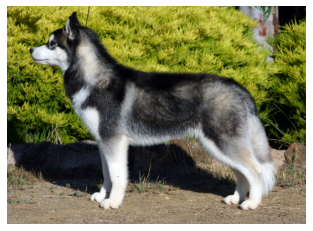

Dog: [0.9999885]
Cat: [1.1503696e-05]

This is a dog!


In [93]:
predict(model, custom_dir + "dog2.jpg")

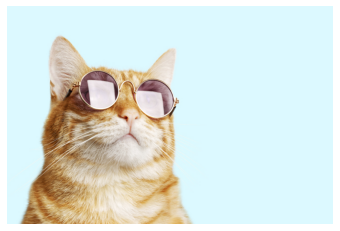

Dog: [0.00055036]
Cat: [0.9994496]

This is a cat!


In [94]:
predict(model, custom_dir + "cat.jpg")

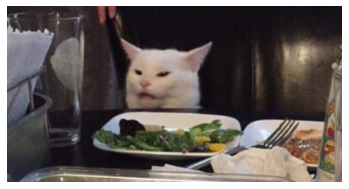

Dog: [1.]
Cat: [0.]

This is a dog!


In [98]:
predict(model, custom_dir + "cat2.jpg")

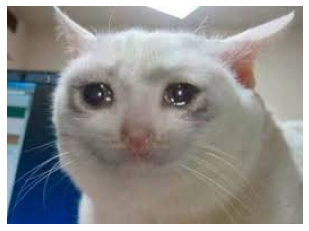

Dog: [4.3462105e-09]
Cat: [1.]

This is a cat!


In [99]:
predict(model, custom_dir + "cat3.jpg")

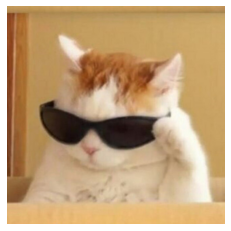

Dog: [2.7391453e-20]
Cat: [1.]

This is a cat!


In [112]:
predict(model, custom_dir + "cat4.jpg")

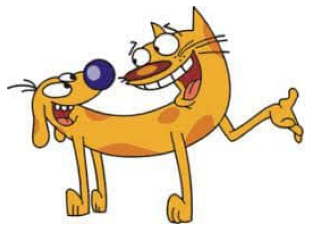

Dog: [0.44471005]
Cat: [0.55529]

This is a cat!


In [100]:
predict(model, custom_dir + "dog_cat.jpg")

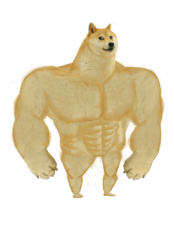

Dog: [0.00273514]
Cat: [0.99726486]

This is a cat!


In [104]:
predict(model, custom_dir + "dog4.jpg")

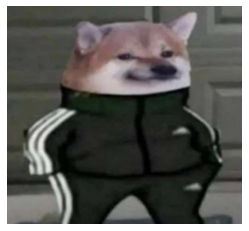

Dog: [0.5442617]
Cat: [0.4557383]

This is a dog!


In [102]:
predict(model, custom_dir + "dog3.jpg")

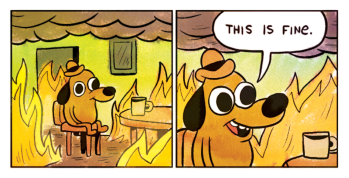

Dog: [0.99925363]
Cat: [0.00074637]

This is a dog!


In [109]:
predict(model, custom_dir + "dog5.png")